# Resonant cavity - Discussion

In [7]:
# Temporary 'hack' for working directory not coinciding with file directory
import os
os.chdir('/home/fenics/shared/examples/resonant_cavity')

%load_ext autoreload
%autoreload 2

In [8]:
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg

import fenics as fen
import mshr
from two_dimensional_cavity import TwoDimensionalCavity
from rectangular_cavity import RectangularCavity

from context import src
from src.vector_space import VectorSpaceL2
from src.minimal_rational_interpolation import MinimalRationalInterpolation
import src.helpers as helpers

## Rectangular cavity

In [9]:
Lx, Ly = 5.0, 1.0
Nx, Ny = 101, 21
m = 1
g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)
RC = RectangularCavity(Lx=Lx, Ly=Ly, Nx=Nx, Ny=Ny, g_N=g_N)
RC.setup()
#RC.plot_g_N()

class inlet(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(x[0], 0.0) and x[1]>0.0 and x[1]<Ly

### Full cavity

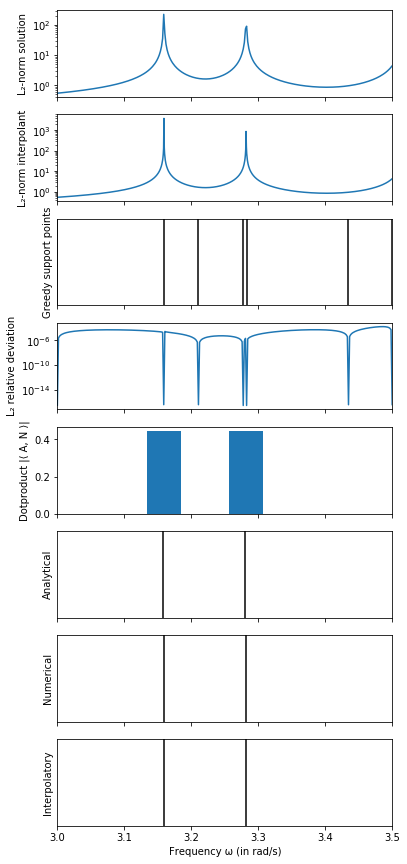

In [22]:
fig, ax = plt.subplots(8, 1, figsize=(6, 15), sharex=True)

a = 3
b = 3.5
omegas = np.linspace(a, b, 300)
RC.solve(omegas)
VS = VectorSpaceL2(RC)
MRI = MinimalRationalInterpolation(VS)
snapshots = RC.get_solution(tonumpy=True, trace=VS.get_trace())
omegas = RC.get_frequency()
MRI.compute_surrogate(snapshots, omegas, greedy=True, tol=1e-1)

ax[0].set_ylabel('L\u2082-norm solution')
helpers.plot_solution_norms(ax[0], RC, VS)

ax[1].set_ylabel('L\u2082-norm interpolant')
helpers.plot_surrogate_norms(ax[1], MRI, VS, a, b)

ax[2].set_ylabel('Greedy support points')
helpers.plot_lines(ax[2], MRI.get_surrogate().get_nodes())

ax[3].set_ylabel('L\u2082 relative deviation')
helpers.plot_surrogate_error_norms(ax[3], RC, MRI, VS)

eigfreqs, eigvecs = RC.get_numerical_eigenfrequencies(a, b, return_eigvecs=True)

ax[4].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
ax[4].bar(eigfreqs, np.abs([np.inner(RC.insert_boundary_values(eigvec), RC.get_N()) for eigvec in eigvecs]), width=0.05)

ax[5].set_ylabel('Analytical')
helpers.plot_lines(ax[5], RC.get_analytical_eigenfrequencies(a, b))

ax[6].set_ylabel('Numerical')
helpers.plot_lines(ax[6], eigfreqs)

ax[7].set_ylabel('Interpolatory')
helpers.plot_lines(ax[7], MRI.get_interpolatory_eigenfrequencies(only_real=True))

ax[-1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[-1].set_xlim(a, b)
plt.show()

#### Progression of relative error in greedy MRI

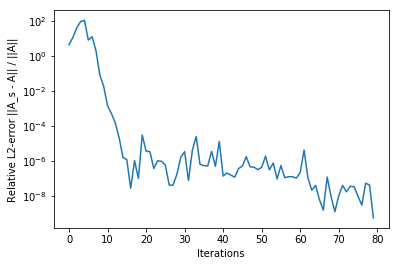

In [96]:
rel_err = MRI.compute_surrogate(snapshots, omegas, greedy=True, tol=1e-9, return_rel_err=True)
plt.plot(rel_err)
plt.yscale('log')
plt.ylabel('Relative L2-error ||A_s - A|| / ||A||')
plt.xlabel('Iterations')
plt.show()

#### Saving the snapshots

In [29]:
RC.save_solution('snapshots/linspace_3.0_3.5_300.obj')

#### Analyzing symmetry of eigenmodes

In [78]:
[omega1, omega2] = eigfreqs

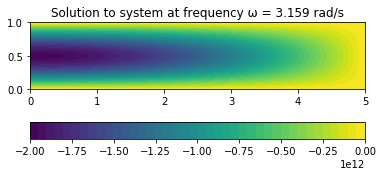

In [79]:
RC.solve(omega1)
RC.plot_solution()

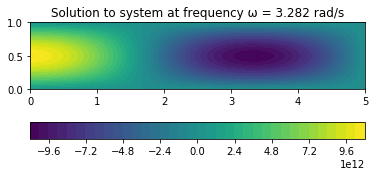

In [80]:
RC.solve(omega2)
RC.plot_solution()

### Inlet of cavity

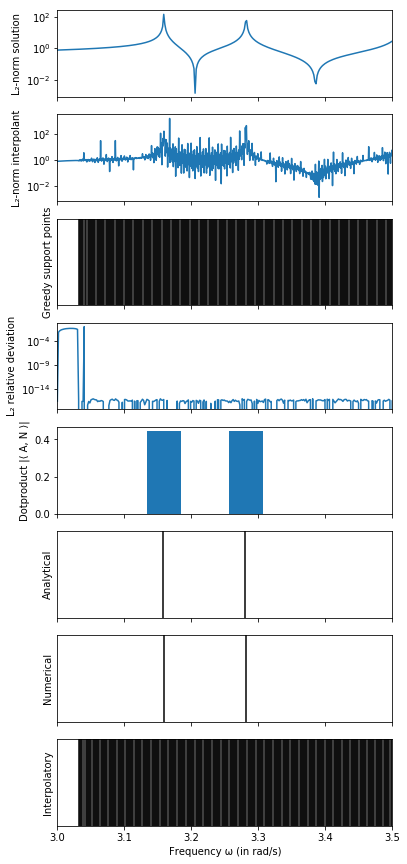

In [81]:
fig, ax = plt.subplots(8, 1, figsize=(6, 15), sharex=True)

a = 3
b = 3.5
omegas = np.linspace(a, b, 300)
RC.solve(omegas)
VS = VectorSpaceL2(RC, inlet())
MRI = MinimalRationalInterpolation(VS)
snapshots = RC.get_solution(tonumpy=True, trace=VS.get_trace())
omegas = RC.get_frequency()
MRI.compute_surrogate(snapshots, omegas, greedy=True, tol=1e-1)

ax[0].set_ylabel('L\u2082-norm solution')
helpers.plot_solution_norms(ax[0], RC, VS)

ax[1].set_ylabel('L\u2082-norm interpolant')
helpers.plot_surrogate_norms(ax[1], MRI, VS, a, b)

ax[2].set_ylabel('Greedy support points')
helpers.plot_lines(ax[2], MRI.get_surrogate().get_nodes())

ax[3].set_ylabel('L\u2082 relative deviation')
helpers.plot_surrogate_error_norms(ax[3], RC, MRI, VS)

eigfreqs, eigvecs = RC.get_numerical_eigenfrequencies(a, b, return_eigvecs=True)

ax[4].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
ax[4].bar(eigfreqs, np.abs([np.inner(RC.insert_boundary_values(eigvec), RC.get_N()) for eigvec in eigvecs]), width=0.05)

ax[5].set_ylabel('Analytical')
helpers.plot_lines(ax[5], RC.get_analytical_eigenfrequencies(a, b))

ax[6].set_ylabel('Numerical')
helpers.plot_lines(ax[6], eigfreqs)

ax[7].set_ylabel('Interpolatory')
helpers.plot_lines(ax[7], MRI.get_interpolatory_eigenfrequencies(only_real=True))

ax[-1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[-1].set_xlim(a, b)
plt.show()

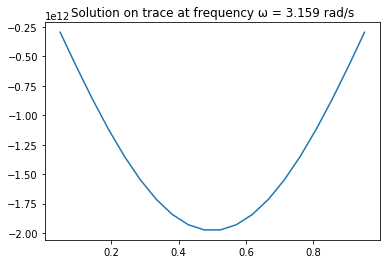

In [82]:
RC.solve(omega1)
RC.plot_solution_trace(inlet())

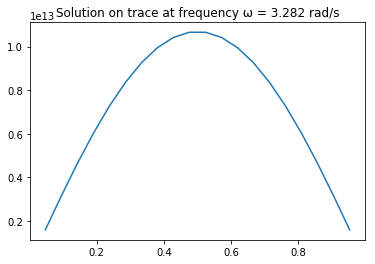

In [83]:
RC.solve(omega2)
RC.plot_solution_trace(inlet())

## Rectangular cavity with cubby (breaking symmetry)

In [84]:
Lx, Ly = 5.0, 1.0

domain = mshr.Rectangle(fen.Point(0.0, 0.0), fen.Point(Lx, Ly)) \
       + mshr.Rectangle(fen.Point(Lx*0.5, Ly), fen.Point(Lx*0.75, Ly*1.25))
mesh = mshr.generate_mesh(domain, 100)

class inlet(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(x[0], 0.0) and x[1]>0.0 and x[1]<Ly

m = 1
g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)
TDC = TwoDimensionalCavity(mesh=mesh, B_N=inlet, g_N=g_N)
TDC.setup()

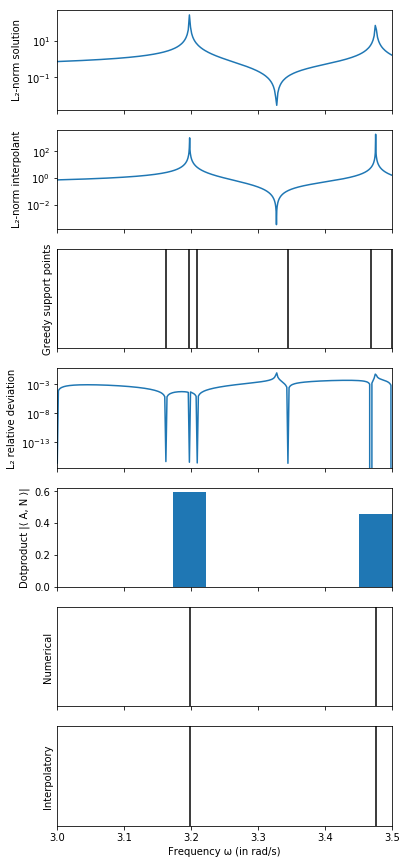

In [85]:
fig, ax = plt.subplots(7, 1, figsize=(6, 15), sharex=True)

a = 3
b = 3.5
omegas = np.linspace(a, b, 300)
TDC.solve(omegas)
VS = VectorSpaceL2(TDC, inlet())
MRI = MinimalRationalInterpolation(VS)
snapshots = TDC.get_solution(tonumpy=True, trace=VS.get_trace())
omegas = TDC.get_frequency()
MRI.compute_surrogate(snapshots, omegas, greedy=True, tol=1e-1)

ax[0].set_ylabel('L\u2082-norm solution')
helpers.plot_solution_norms(ax[0], TDC, VS)

ax[1].set_ylabel('L\u2082-norm interpolant')
helpers.plot_surrogate_norms(ax[1], MRI, VS, a, b)

ax[2].set_ylabel('Greedy support points')
helpers.plot_lines(ax[2], MRI.get_surrogate().get_nodes())

ax[3].set_ylabel('L\u2082 relative deviation')
helpers.plot_surrogate_error_norms(ax[3], TDC, MRI, VS)

eigfreqs, eigvecs = TDC.get_numerical_eigenfrequencies(a, b, return_eigvecs=True)

ax[4].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
ax[4].bar(eigfreqs, np.abs([np.inner(TDC.insert_boundary_values(eigvec), TDC.get_N()) for eigvec in eigvecs]), width=0.05)

ax[5].set_ylabel('Numerical')
helpers.plot_lines(ax[5], eigfreqs)

ax[6].set_ylabel('Interpolatory')
helpers.plot_lines(ax[6], MRI.get_interpolatory_eigenfrequencies(only_real=True))

ax[-1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[-1].set_xlim(a, b)
plt.show()

In [86]:
[omega1, omega2] = eigfreqs

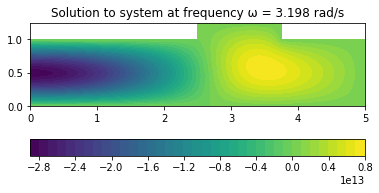

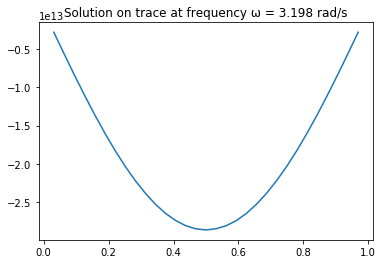

In [87]:
TDC.solve(omega1)
TDC.plot_solution()
TDC.plot_solution_trace(inlet())

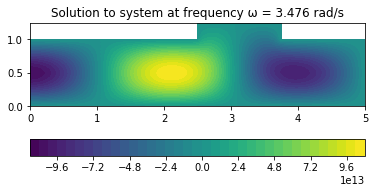

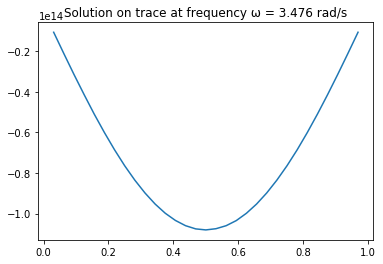

In [88]:
TDC.solve(omega2)
TDC.plot_solution()
TDC.plot_solution_trace(inlet())

#### Compare methods

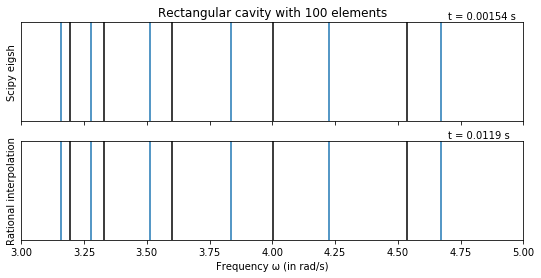

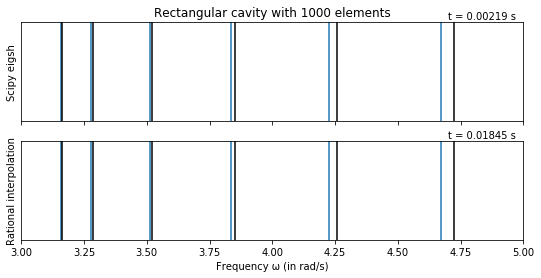

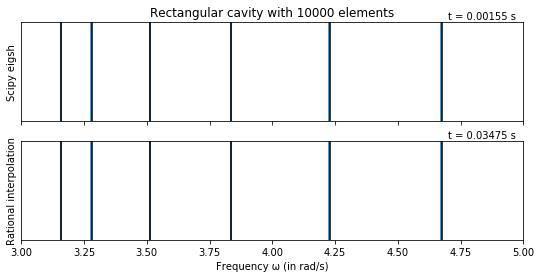

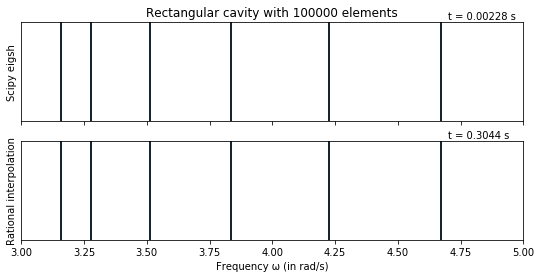

In [89]:
Lx, Ly = 5.0, 1.0
m = 1
g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)

a = 3
b = 5
omegas = np.linspace(a, b, 100)

for N in np.logspace(2, 5, 4, dtype=int):
    RC = RectangularCavity(Lx=Lx, Ly=Ly, Nx=int(pow(N*Lx/(Lx+Ly), 0.5)), Ny=int(pow(N*Ly/(Lx+Ly), 0.5)), g_N=g_N)
    RC.setup()
    RC.solve(omegas)
    VS = VectorSpaceL2(RC)
    snapshots = RC.get_solution(tonumpy=True, trace=VS.get_trace())
    fig, ax = plt.subplots(2, 1, figsize=(9, 4), sharex=True)
    t0 = time.time()
    helpers.plot_lines(ax[0], RC.get_analytical_eigenfrequencies(a, b), color='C0')
    t_FE = time.time() - t0
    helpers.plot_lines(ax[0], RC.get_numerical_eigenfrequencies(a, b))
    helpers.plot_lines(ax[1], RC.get_analytical_eigenfrequencies(a, b), color='C0')
    t0 = time.time()
    MRI = MinimalRationalInterpolation(VS)
    MRI.compute_surrogate(snapshots, omegas, greedy=True, tol=1e-2)
    helpers.plot_lines(ax[1], MRI.get_interpolatory_eigenfrequencies(only_real=True))
    t_RI = time.time() - t0
    ax[0].set_title(f'Rectangular cavity with {N} elements')
    ax[0].set_ylabel('Scipy eigsh')
    ax[0].text(0.85, 1.03, f't = {round(t_FE, 5)} s', transform=ax[0].transAxes)
    ax[0].set_yticks([])
    ax[1].set_ylabel('Rational interpolation')
    ax[0].text(0.85, 1.03, f't = {round(t_RI, 5)} s', transform=ax[1].transAxes)
    ax[1].set_yticks([])
    ax[1].set_xlabel('Frequency \u03C9 (in rad/s)')
    ax[1].set_xlim(a, b)
    plt.show()